##  Data generation

Given covariance function $cov(k(x, y))$, need generate random field with given covariance

In [1]:
%matplotlib inline
import numpy as np
import scipy.sparse as scsp
import matplotlib.pyplot as plt
import scipy.linalg as sclin
import scipy.sparse.linalg as scspl

In [2]:
def cov_func(points, alpha=1, beta=1):
    '''
    Function generated covariance matrix for given points 
    and parameters alpha and beta
    '''
    n = points.shape[0]
    A = np.zeros((n, n))
    for i in xrange(n):
        for j in xrange(n):
            norm = np.linalg.norm(points[i] - points[j])
            A[i, j] = np.exp(-norm**alpha / beta) 
    return A

In [3]:
def col_covmatrix(points, alpha=1, beta=1):
    '''
    Function generates first column of the 
    covariance matrix to store it efficiently
    '''
    n = points.shape[0]
    A = np.zeros((n,))
    for i in xrange(n):
        norm = np.sqrt((points[i, 0] - points[0, 0])**2 + (points[i, 1] - points[0, 1])**2)
        A[i, ] = np.exp(-norm**alpha / beta)
    return A

In [4]:
def symtoeplitz2circulant(A):
    '''
    Function converts the first column of 
    symmetrix toeplitz matrix to the first
    column of circulant matrix
    '''
    n = A.shape[0]
    col = np.zeros((2*(n-1), ))
    col[:n] = A[:n]
    col[n:] = A[-2:-n:-1]
    return col

In [5]:
def coltoeplitz2colcircuant(A):
    '''
    Function converts first column of 
    BTTB to first column of BCCB
    '''
    n = A.shape[0]
    m = int(round(np.sqrt(n)))
    num_blocks = n / m
    B = np.zeros(((2*(m-1))**2, ))
    for i in xrange(num_blocks):
        B[i*(2*(m-1)):(i+1)*(2*(m-1))] = symtoeplitz2circulant(A[i*num_blocks:(i+1)*num_blocks])
    for j in xrange(num_blocks-2):
        B[2*(m-1)*(num_blocks+j):2*(m-1)*(num_blocks+j+1)] = B[2*(m-1)*(num_blocks-2-j):2*(m-1)*(num_blocks-1-j)]
    return B

## Create matrix and solve PDE

In [6]:
def create_matrix(covar, rhs):
    '''
    Function create matrix and rhs to solve discretized 
    general Poisson equation in the form div(k grad(u)) = rhs
    '''
    n = covar.shape[0]
    A = scsp.lil_matrix((n**2, n**2))
    b = np.zeros((n*n, ))
    inner_points2ind = {}
    bound_points2ind = {}
    k = 0
    for i in xrange(n):
        for j in xrange(n):
            if i == 0 or j == 0 or i == n-1 or j == n-1:
                bound_points2ind[(i, j)] = k
                k += 1
            else:
                inner_points2ind[(i, j)] = k
                k += 1
    ind2inner_points = {inner_points2ind[key]: key for key in inner_points2ind}
    ind2bound_points = {bound_points2ind[key]: key for key in bound_points2ind}
    for k in ind2inner_points:
        i, j = ind2inner_points[k]
        b[k] = rhs[i, j]
        A[k, k] = -(covar[i, j+1] + covar[i-1, j] + covar[i+1, j] + covar[i, j-1] + 4*covar[i, j]) / 2
        if j + 1 != n -1:
            l1 = inner_points2ind[(i, j+1)]
        else:
            l1 = bound_points2ind[(i, j+1)]
        A[k, l1] = (covar[i, j+1] + covar[i, j]) / 2
        
        if j - 1 != 0:
            l2 = inner_points2ind[(i, j-1)]
        else:
            l2 = bound_points2ind[(i, j-1)]
        A[k, l2] = (covar[i, j-1] + covar[i, j]) / 2
        
        if i + 1 != n-1:
            k1 = inner_points2ind[(i+1, j)]
        else:
            k1 = bound_points2ind[(i+1, j)]
        A[k, k1] = (covar[i+1, j] + covar[i, j]) / 2
        
        if i-1 != 0:
            k2 = inner_points2ind[(i-1, j)]
        else:
            k2 = bound_points2ind[(i-1, j)]
        A[k, k2] = (covar[i-1, j] + covar[i, j]) / 2
    
    for k in ind2bound_points:
        A[k ,k] = 1
    A = A * (n-1)**2
    return A, b, ind2inner_points, ind2bound_points

In [7]:
def solve(random_field, rhs):
    '''
    Function solves the PDE div(k grad(u)) = rhs for 
    given k and rhs
    '''
    n = rhs.shape[0]
    A, b, ind2inner, ind2bound = create_matrix(random_field, rhs)
    x = scspl.spsolve(A, b)
    u = np.zeros((n, n))
    for k in ind2inner:
        i, j = ind2inner[k]
        u[i, j] = x[k]
    for k in ind2bound:
        i, j = ind2bound[k]
        u[i, j] = x[k]
    plt.figure()
    plt.imshow(u)
    plt.colorbar()
    plt.figure()
    plt.imshow(random_field)
    plt.colorbar()
    return u

In [8]:
def create_random_field(col_A, n):
    '''
    Function creates random field for given first
    column of the covariance matrix
    '''
    col_circ = coltoeplitz2colcircuant(col_A)
    key_col = col_circ
    key_mat = np.reshape(key_col, (2*(n-1), 2*(n-1)))
    fft_key_mat = np.fft.fft2(key_mat)
    Lam = np.sqrt(fft_key_mat)
    x = np.random.randn(2*(n-1), 2*(n-1)) + 1j*np.random.randn(2*(n-1), 2*(n-1))
    rand_field = np.fft.ifft2(Lam * (np.fft.fft2(x)))[:n, :n]
    random_field = rand_field.imag
    return random_field 

In [9]:
def integrate(u):
    n = u.shape[0]
    h = 1.0 / n
    val = h**2 * np.sum(u[40:80, 40:80])
    return val

## Demo script

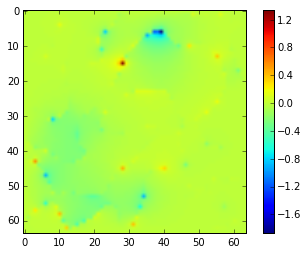

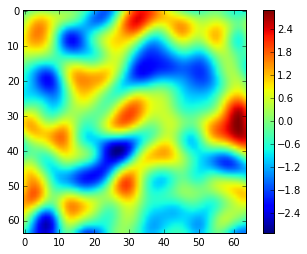

In [13]:
n = 64
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
xv, yv = np.meshgrid(x, y)
p = np.hstack((xv.reshape((n*n, 1)), yv.reshape((n*n, 1))))
size = 1
X = np.zeros((size, 1, n, n))
y = np.zeros(size)
for t in xrange(size):
    col_A = col_covmatrix(p, 2, 1e-2)
    rhs = np.ones((n, n))
    random_field = create_random_field(col_A, n)
    u = solve(random_field, rhs)
    val = integrate(u)
    X[t, 0, :, :] = u
    y[t] = val
    
X = X.astype(np.float32)
y = y.astype(np.float32)
nidx = X.shape[0]
idx = range(nidx)
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

In [11]:
y = y.reshape((-1, 1))
print y.shape

(1, 1)


## Use DLNN to predict $y$ base on random field

In [ ]:
from lasagne.nonlinearities import softmax, rectify, tanh, identity
from nolearn.lasagne import NeuralNet
from lasagne.layers import InputLayer, DenseLayer, Conv2DLayer, MaxPool2DLayer
from lasagne.updates import nesterov_momentum, adagrad

In [14]:
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = [w.get_value() for w in nn.get_all_params()]
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_weights_from(self.best_weights)
            raise StopIteration()

In [15]:
net = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', InputLayer),
        ("conv1", Conv2DLayer),
        ("pool1", MaxPool2DLayer),
#         ("conv2", Conv2DLayer),
#         ("pool2", MaxPool2DLayer),
#         ("conv3", Conv2DLayer),
#         ("pool3", MaxPool2DLayer),
#         ("conv4", Conv2DLayer),
#         ("pool4", MaxPool2DLayer),
#         ("conv5", Conv2DLayer),
#         ("pool5", MaxPool2DLayer),
        ('hidden1', DenseLayer),
        ('hidden2', DenseLayer),
        ('output', DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 1, 64, 64),
    conv1_num_filters=64, conv1_filter_size=(3, 3), 
    pool1_pool_size=(2, 2),
#     conv2_num_filters=128, conv2_filter_size=(3, 3), 
#     pool2_pool_size=(2, 2),
#     conv3_num_filters=256, conv3_filter_size=(3, 3), 
#     pool3_pool_size=(2, 2),
#     conv4_num_filters=512, conv4_filter_size=(3, 3), 
#     pool4_pool_size=(2, 2),
    hidden1_num_units=100,
    hidden2_num_units=150, hidden2_nonlinearity=tanh, 
    output_nonlinearity=None, output_num_units=1,

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=20,  # we want to train this many epochs
    verbose=1,
    on_epoch_finished=[EarlyStopping(patience=7),],
    )

In [16]:
net.fit(X, y)

  input             	(None, 1, 64, 64)   	produces    4096 outputs
  conv1             	(None, 64, 62, 62)  	produces  246016 outputs
  pool1             	(None, 64, 31, 31)  	produces   61504 outputs
  hidden1           	(None, 100)         	produces     100 outputs
  hidden2           	(None, 150)         	produces     150 outputs
  output            	(None, 1)           	produces       1 outputs
  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.09438       0.32640      0.28916  0.09s
      2       0.95401       0.02529     37.72532  0.10s
      3       0.05674       0.01759      3.22486  0.10s
      4       0.02940       0.01046      2.81163  0.10s
      5       0.01973       0.00463      4.25835  0.09s
      6       0.01299       0.00138      9.38979  0.10s
      7       0.00630       0.00040     15.86645  0.10s
      8       0.00266       0.00117      2.28020  0.11s
      9       0.00280       0.00256     

d:\src\lasagne\lasagne\init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
c:\Users\Alex\Anaconda\lib\site-packages\nolearn\lasagne\base.py:449: UserWarning: The 'load_weights_from' method will be removed in nolearn 0.6. Please use 'load_params_from' instead.
  warn("The 'load_weights_from' method will be removed in nolearn 0.6. "



Best valid loss was 0.000397 at epoch 7.


ValueError: Loading weights from a list of parameter values is no longer supported.  Please send me something like the return value of 'net.get_all_param_values()' instead.

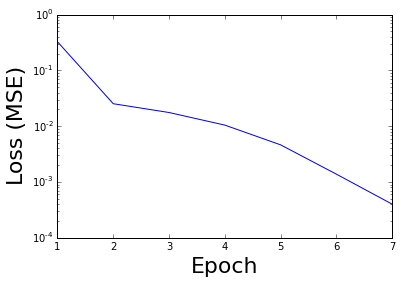

In [25]:
ep = range(1, 8)
loss = [0.32640, 0.02529, 0.01759, 0.01046, 0.00463, 0.00138, 0.00040] 
plt.plot(ep, loss)
plt.semilogy()
plt.xlabel("Epoch", size=22)
plt.ylabel("Loss (MSE)", size=22)